# Analyzing “War and Peace” Using Neo4j and Python

In [1]:
import pprint # for pretty printing 

## Install Neo4j Driver

In [2]:
# pip install neo4j-driver

## Connection to Neo4j

In [3]:
# See what modules you have installed with the pip install command to this point.
# pip freeze

In [4]:
from neo4j import GraphDatabase

In [5]:
# Create an instance of the driver object
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth = ("neo4j", "warandpeace"))

In [6]:
# Create an instance of the session object
session = driver.session()
result = session.run("MATCH (n) RETURN COUNT(n) AS num")
for record in result:
    display(record)

<Record num=10511>

## Task 1.
Use Python to extract information from raw ‘War and Peace” text file, the same way we did it in
HW 2, but this time populating the Neo4j database instead of MongoDB. You will have “Person”
nodes, for each character in the list, “Paragraph” nodes (with lineNumber property) for each
paragraph that mentions any of the characters, with “CONTAINS” relationship between them.
Do not count empty lines (just skip them)! After this task we do not use the raw text at all, and
complete the rest of the tasks using this database data only.

In [7]:
filepath = 'WarAndPeace_Altered.txt'

with open(filepath) as fp: # if you are using Linux or Mac, you may need to use decode() function.

    line = fp.readline() # Reads the first line
    names = {"Natasha", "Pierre", "Denisov", "Nicholas", "Countess Mary", "Kutuzov", "Bolkonski", "Napoleon", "Prince Andrew", "Dolokhov", "Anna Pavlovna", "Helene", "Princess Mary", "Prince Vasili", "Bezukhov", "Boris",  "Sonya", "Rostovs", "Anatole"}
    parCnt = 0 # Counter for all encountered paragraphs
    parNamesHitCnts = []
    
    while line:
        if len(line) > 1: # Check if this line is not empty (i.e. has no text).
            parCnt += 1
            namesHitCnts = []
            for name in names:
                nameHitCnt = 0
                idxBegin = 0
                idxFound = line[idxBegin:].find(name)
                while idxFound >= 0: # A hit occured & Looping for more occurances.
                    nameHitCnt += 1 # Count number of hits for a given name
                    idxBegin = idxFound + len(name) + idxBegin # Move the beginning of the next search after the previously found name wrt the overall line
                    idxFound = line[idxBegin:].find(name) # Search from a substring
                
                if nameHitCnt >= 1: namesHitCnts.append({"name": name, "count": nameHitCnt}) # Dictionary of names and respective hit count per paragraph
            
            #pprint.pprint(line); pprint.pprint(namesHitCnts)
            if len(namesHitCnts) >= 1: parNamesHitCnts.append({ "paragraph": parCnt, "hits": namesHitCnts }) # for all paragraphs that contain at least 1 name.
            
        line = fp.readline() # Read the next line
        
    print(len(parNamesHitCnts))

5179


In [8]:
 result = session.run("MATCH (n:Paragraph) DETACH DELETE n;")
 result = session.run("MATCH (n:Person) DETACH DELETE n;")

In [9]:
cypherQP = """
UNWIND $parNamesHitCnts AS row
MERGE (ph:Paragraph {lineNumber: row.paragraph})
WITH row, ph
UNWIND row.hits AS hit
MERGE (pn:Person {name: hit.name})
MERGE (ph)-[r:CONTAINS{count: hit.count}]->(pn)
"""

In [10]:
result = session.run(cypherQP, parameters={"parNamesHitCnts": parNamesHitCnts});

## Task 2.
Similar to HW 3, use Python to run Cypher commands on your database to create the following
relationships:

### a. CO_MENTIONED_WITH relationship
If two characters are mentioned within the same paragraph, create CO_MENTIONED_WITH
relationships between them. Additionally, this relationship should have a property ‘number’
that should reflect the number of paragraphs in which the characters are mentioned together.


In [11]:
cypherQ = """
MATCH (n1:Person)<-[r1:CONTAINS]-(p:Paragraph)-[r2:CONTAINS]->(n2:Person)
WITH n1, n2, COUNT(p) AS cp
MERGE (n1)-[r3:CO_MENTIONED_WITH{number:cp}]->(n2)
MERGE (n1)<-[r4:CO_MENTIONED_WITH{number:cp}]-(n2)
"""

In [12]:
result = session.run(cypherQ);

### b. STRONGEST relationship
Create the STRONGEST relationship for each character, just as it is discussed in HW 3.

In [13]:
cypherQ = """
MATCH (n1:Person)-[r1:CO_MENTIONED_WITH]->(Person)
WITH n1, MAX(r1.number) AS max
ORDER BY max desc
MATCH (n1)-[r2:CO_MENTIONED_WITH]->(n2:Person)
WHERE r2.number = max
MERGE (n1)-[r3:STRONGEST]->(n2)
"""

In [14]:
result = session.run(cypherQ);

## Task 3.
Write Python code that will first extract the information from the database and then construct
various graphs based on that data. Make sure that you have numPy and matplotlib installed
(usually comes with standard Anaconda distribution).

In [15]:
# Ref: https://www.geeksforgeeks.org/graph-plotting-python-set-1/ 
# Ref: https://www.geeksforgeeks.org/graph-plotting-python-set-2/
# Ref: https://www.geeksforgeeks.org/graph-plotting-python-set-3/

# Library Import
import matplotlib.pyplot as plt

# Select Plot Style
#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

### a. Graph of cumulative mentions for a given character (using a function with a parametrized query)
The task is to construct a line graph, where on the x-axis you would have paragraph line
numbers, and on the y-axis, the number of cumulative mentions of that character by that time.
For example, if for a paragraph 500 you have 32 on the y-axis for ‘Natasha’, that means that by
the time paragraph 500 is finished, Natasha has been mentioned in the text so far 32 times in
total. The graph will of course be always non-decreasing.

Another requirement here is to ​implement it by
defining a function​ ​graph_mentions(name)​ ​that will
take a string with the character's name as an input
and execute this task. In other words to produce this
graph one should simply call:
graph_mentions(“Sonya”)
You should have a parametrized query inside of the
function that will use name as the parameter.

In [16]:
def dataRetrieve(name):
    cypherQP = ("MATCH (n1:Person{name:$name})<-[r1:CONTAINS]-(n2:Paragraph) "
               "WITH n2.lineNumber AS line, r1.count AS count "
               "ORDER BY line ASC "
               "RETURN line, count ")
    result = session.run(cypherQP, parameters={"name": name});
    x = []; y = []; yCumulative = 0;
    for record in result:
        x.append(record["line"])
        yCumulative = record["count"] + yCumulative
        y.append(yCumulative)
    data = {"x": x, "y": y}
    return data

In [17]:
def graph_mentions(name):
    data = dataRetrieve(name)
    
    # Create a plot of x
    plt.plot(data["x"], data["y"]) 
    # Place a label on the x axis :
    plt.xlabel('x - axis: Paragraph Line Number') 
    # y axis label: 
    plt.ylabel('y - axis: Cumulative Mentions') 
    # Graph title 
    plt.title('Cumulative Mentions of '+name) 
    # This will show the clean plot:
    plt.show()    

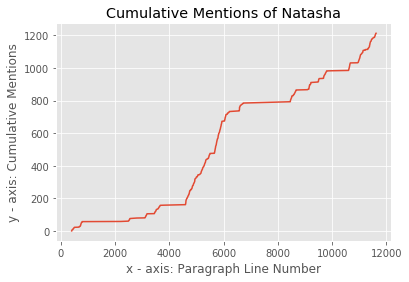

In [18]:
graph_mentions("Natasha")

### b. Graph of cumulative mentions for TWO given character
Same as above, except you should have two characters picked and both graphs plotted together
(in the same plot). 

In [19]:
def graph_2lines_mentions(name1, name2):
    data1 = dataRetrieve(name1)
    data2 = dataRetrieve(name2)

    plt.plot(data1["x"], data1["y"], label = name1) 
    plt.plot(data2["x"], data2["y"], label = name2)
    # Place a label on the x axis :
    plt.xlabel('x - axis: Paragraph Line Number') 
    # y axis label: 
    plt.ylabel('y - axis: Cumulative Mentions') 
    # Graph title 
    plt.title('Cumulative Mentions of '+name1+' and '+name2)  
    # Show plot legend
    plt.legend() 
    # This will show the clean plot:
    plt.show()  

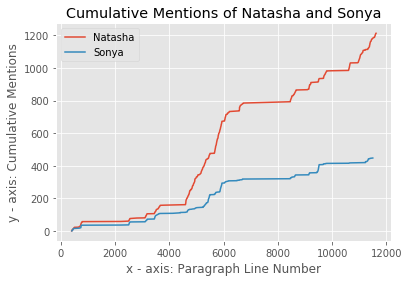

In [20]:
graph_2lines_mentions("Natasha", "Sonya")

### c. Construct a histogram of mentions for a given character
Construct a histogram reflecting how often the given character is mentioned throughout the
book. Use matplotlib’s ​hist ​command. Use 50 bins for the histogram (i.e. take the range of the
paragraph line numbers and split it in 50 subranges).
Create a plot with 4 subplots, showing histograms for “Natasha”, “Pierre”, “Prince Andrew” and
“Napoleon”, respectively.

In [21]:
def plotHist(plt, name):
    data = dataRetrieve(name)
    
    # frequencies 
    freq = data["x"]
    # setting the ranges and no. of intervals 
    range = (data["y"][0] , data["y"][len(data["y"])-1]) 
    bins = 50
    # plotting a histogram 
    plt.hist(freq, bins, range, color = 'lightblue', histtype = 'bar', rwidth = 0.8) 
    plt.set_title(name) 
    # x-axis label 
    #plt.xlabel("Paragraph Line Number") 
    # frequency label 
    #plt.ylabel("Count of Mentions")
    
def graph_4hist_Mentions(name1, name2, name3, name4):
    # create a figure 
    fig = plt.figure() 

    # define subplots and their positions in figure 
    plt1 = fig.add_subplot(221) 
    plt2 = fig.add_subplot(222) 
    plt3 = fig.add_subplot(223) 
    plt4 = fig.add_subplot(224) 

    plotHist(plt1, name1)
    plotHist(plt2, name2)
    plotHist(plt3, name3)
    plotHist(plt4, name4)

    # adjusting space between subplots 
    fig.subplots_adjust(hspace=.5,wspace=0.5) 

    plt.show()

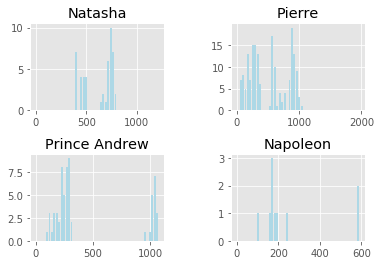

In [22]:
graph_4hist_Mentions("Natasha", "Pierre", "Prince Andrew", "Napoleon")

## Task 4.
Write Python code to run some graph algorithms on the database. Make sure to install the
‘Graph Data Science Library’ plugin to Neo4j.​ (Don’t use the latest version of Neo4j)​.
### a. Compute PageRank for all characters and plot them.
Using Person nodes and STRONGEST relationships only compute PageRank for each node.
Construct a ​pie chart ​with the PageRank of each character. Here’s a description on how to use
GDS specifically for PageRank: ​(The PageRank algorithm)

In [23]:
# Ref: https://neo4j.com/docs/graph-data-science/current/management-ops/graph-catalog-ops/#catalog-graph-drop
#cypherQ = ("CALL gds.graph.drop('WarAndPeace_Graph1')")
#result = session.run(cypherQ);

In [24]:
cypherQ = ("CALL gds.graph.create( "
           "'WarAndPeace_Graph1', "
           "'Person', "
           "'STRONGEST')")
result = session.run(cypherQ);

In [25]:
# Ref: https://neo4j.com/docs/graph-data-science/current/algorithms/page-rank/
cypherQ = """
CALL gds.pageRank.stream('WarAndPeace_Graph1')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score
ORDER BY score DESC
"""
result = session.run(cypherQ);
names = []; scores = []
for rec in result:
    names.append(rec["name"])
    scores.append(rec["score"])

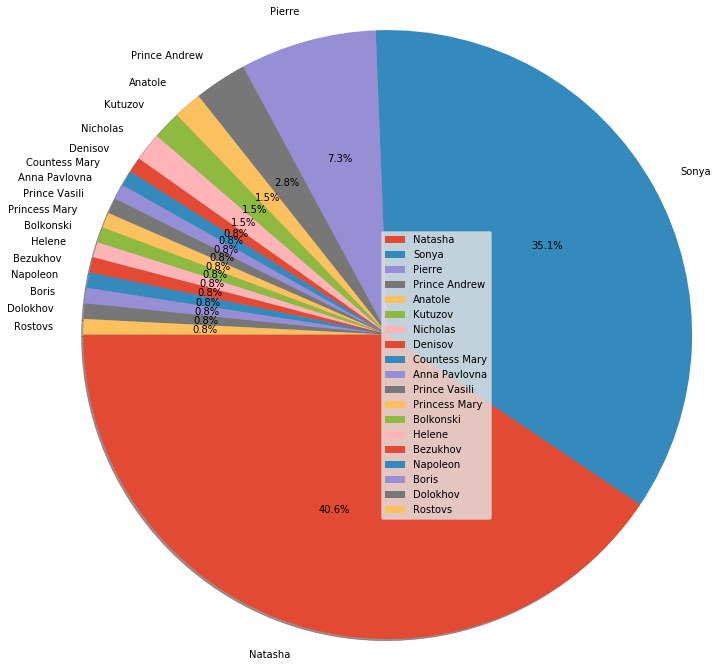

In [26]:
# plotting the pie chart 
plt.pie(scores, labels = names, 
        startangle = 180, shadow = True,
        radius = 3.5, autopct = '%1.1f%%') 
# plotting legend 
plt.legend() 
plt.show()

### b. Compute Betweenness Centrality for all characters and plot it.
Using Person nodes and STRONGEST relationships only compute Betweenness Centrality for
each node. Construct a ​bar chart​ with the centrality measure of each character.

In [27]:
#Ref: https://neo4j.com/docs/graph-data-science/current/algorithms/betweenness-centrality/#algorithms-betweenness-centrality-examples
cypherQ = """
CALL gds.betweenness.stream('WarAndPeace_Graph1')
YIELD nodeId, score 
RETURN gds.util.asNode(nodeId).name AS name, score
ORDER BY score DESC
"""
result = session.run(cypherQ);
#display(list(result))
names = []; scores = []
for rec in result:
    names.append(rec["name"])
    scores.append(rec["score"])

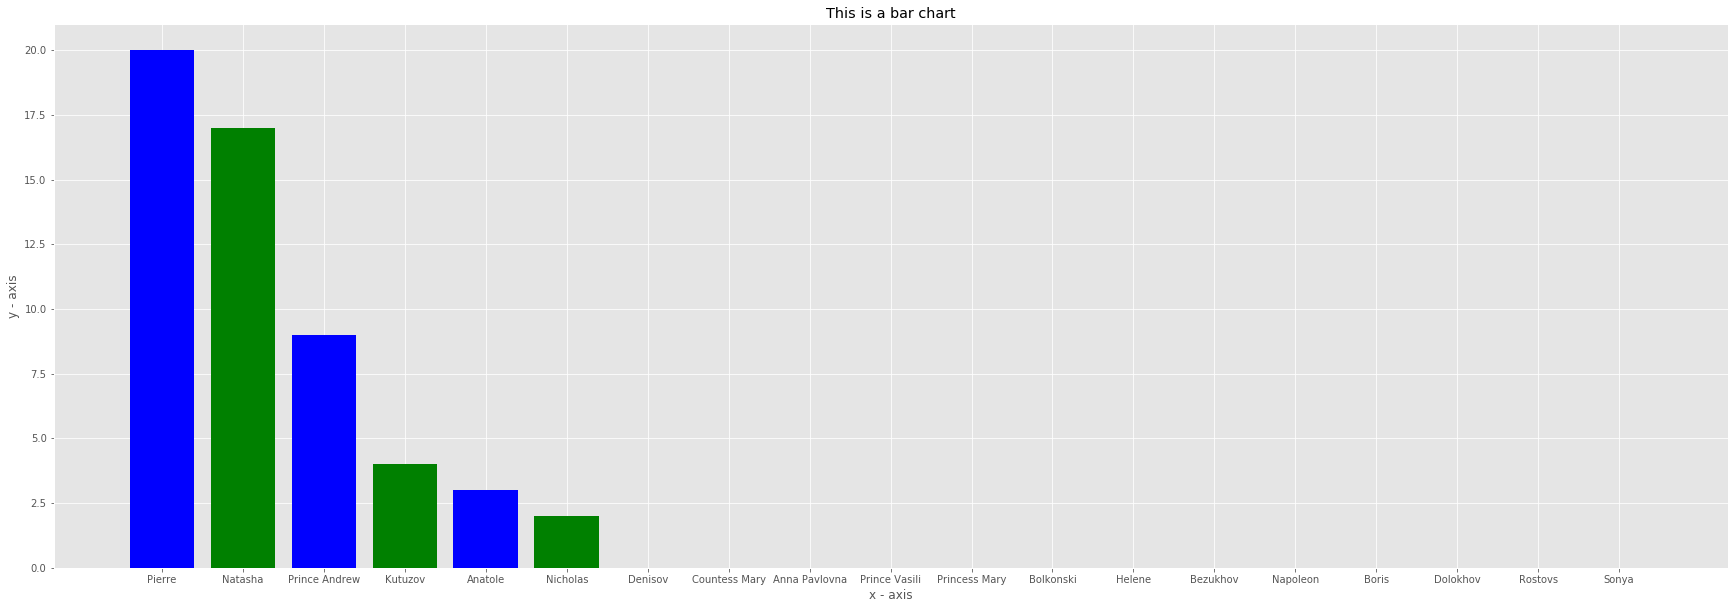

In [28]:
# plotting a bar chart
plt.subplots(figsize=(30,10))
plt.bar(names, scores, width = .8, color = ['Blue', 'green']) 
#it will cycle through the given colors
  
# naming the x-axis 
plt.xlabel('x - axis') 
# naming the y-axis 
plt.ylabel('y - axis') 
# plot title 
plt.title('This is a bar chart') 
  
plt.show() 

### c. Use Label Propagation to determine communities of characters.
Using Person nodes and CO_MENTIONED_WITH relationships (with weights!) to find
communities of characters and print them out.

In [29]:
# Ref: https://neo4j.com/docs/graph-data-science/current/management-ops/graph-catalog-ops/#catalog-graph-drop
#cypherQ = ("CALL gds.graph.drop('WarAndPeace_Graph2')")
#result = session.run(cypherQ);

In [30]:
cypherQ = ("CALL gds.graph.create( " 
           "'WarAndPeace_Graph2', "
           "'Person', "
           "'CO_MENTIONED_WITH', "
           "{relationshipProperties: 'number'})")
result = session.run(cypherQ);

In [31]:
# Ref: https://neo4j.com/docs/graph-data-science/current/algorithms/label-propagation/
cypherQ = ("CALL gds.labelPropagation.stream('WarAndPeace_Graph3', { relationshipWeightProperty: 'number' }) "
           "YIELD nodeId, communityId AS Community "
           "RETURN gds.util.asNode(nodeId).name AS Name, Community "
           "ORDER BY Community, Name")
result = session.run(cypherQ);
display(list(result))
names = []; scores = []
for rec in result:
    names.append(rec["name"])
    scores.append(rec["score"])

[<Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>,
 <Record Name=None Community=2734>]

In [421]:
session.close()